In [1]:
# Load Some Packages
import numpy as np
import imageio
import scipy as sp
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
import os, glob, ntpath
from tqdm import tqdm

In [2]:
import import_ipynb

In [3]:
from plot_3d import plotMatrix

importing Jupyter notebook from plot_3d.ipynb


In [4]:
# Given Some Coefficients in Partial(K)/Partial(t)
D = 0.75

# Given Some Coefficients in F(K)
A = -0.3
Kr = 0.03
Ktheta = 0.2
Km = 1.0

# Given Some Coefficients in Partial(r)/Partial(t)
B = 0.0001
C = 10.0

# max & min in colorbar
vmax = 1.0
vmin = 0.0

In [5]:
# Given the range of the rectangle
lenX = 50
lenY = 50
lenZ = 50

deltaX = 0.025 # mm
deltaY = 0.025 # mm
deltaZ = 0.025 # mm
# deltaT = (deltaX*deltaY*deltaZ)**2/(deltaX**2 + deltaY**2 + deltaZ**2)/2/D
deltaT = 0.000025
deltaT

2.5e-05

In [6]:
# Definie the filter of the laplacian operator
filter_laplacian = np.array([[[0, 0, 0],
                           [0, 1/deltaX**2, 0],
                           [0, 0, 0]],
                            [[0, 1/deltaZ**2, 0],
                           [1/deltaY**2, - 2/deltaX**2 - 2/deltaY**2 - 2/deltaZ**2, 1/deltaY**2],
                           [0, 1/deltaZ**2, 0]],
                            [[0, 0, 0],
                           [0, 1/deltaX**2, 0],
                           [0, 0, 0]]])

filter_laplacian

array([[[    0.,     0.,     0.],
        [    0.,  1600.,     0.],
        [    0.,     0.,     0.]],

       [[    0.,  1600.,     0.],
        [ 1600., -9600.,  1600.],
        [    0.,  1600.,     0.]],

       [[    0.,     0.,     0.],
        [    0.,  1600.,     0.],
        [    0.,     0.,     0.]]])

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

In [66]:
L = np.copy(K[:,:,:])
L[0,0,0] = 1
L[49,49,49]=0
L[2:48,2:48,2:48] = 0.9

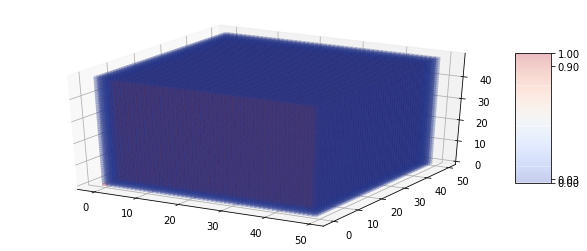

In [67]:
fig = plt.figure(figsize=(10,4))
ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
plotMatrix(ax, range(50), range(50), range(50),L, cmap="coolwarm", cax = ax_cb)

In [7]:
def do_3d_time_step( target_array, filter_3d_laplacian, boundary):
    
    # target_array is l*m*n
    # filter_3d_laplacian is 3*3*3
    
    result_array = np.zeros(target_array.shape)
    
    # mode == 'same'

    if np.max(target_array) > np.min(target_array):
        for i in range(1,lenX-1):
            for j in range(1,lenY-1):
                for k in range(1,lenZ-1):
                    result_array[k,j,i] = np.sum(target_array[k-1:k+2,j-1:j+2,i-1:i+2]*filter_3d_laplacian) #np.sum(target_array[k-1:k+2,j-1:j+2,i-1:i+2]*filter_3d_laplacian)

#     if boundary == 'Diri' or boundary == 'Neum':
#         return result_array 
    
#     elif boundary == 'Perid':
        
        
    if boundary == 'Perid':
        
        temp_array = np.copy(target_array[-1,:,:])
        temp_array = np.vstack(temp_array,target_array[:2,:,:])
#         for i in range(lenX):
#             for j in range(lenY):
#                 result_array[0,j,i] = np.sum(target_array[]*filter_3d_laplacian)
    
    return result_array 

In [8]:
def Dirichlet_bd(maxIter, clamping_value, clamping_radius,
                 clamping_ticks, clamping_ticks_end,
                 foucs_loc,
                 K, Kt, R, Rt,
                 top, bottom, front, back, left, right):
    
    center_point_loc = int(lenX/2)
    center_point_loc = np.vstack((center_point_loc, int(lenY/2)))
    center_point_loc = np.vstack((center_point_loc, int(lenZ/2)))
    point_value = np.zeros([maxIter, foucs_loc.shape[0]])
    R_value = np.zeros([maxIter, foucs_loc.shape[0]])
    
#     # Fixed the boundary values
#     K[0,:,:] = left
#     K[-1,:,:] = right
#     K[:,0,:] = front
#     K[:,-1,:] = back
#     K[:,:,0] = top
#     K[:,:,-1] = bottom
    
    for i in tqdm(range(maxIter)):
        
        if i >= clamping_ticks and i <= clamping_ticks_end:  
            r2 = clamping_radius**2
            for a in range(lenX):
                for b in range(lenY):
                    for c in range(lenZ):
                        dis2 = (a-center_point_loc[0])**2 + (b-center_point_loc[1])**2 + (c-center_point_loc[1])**2
                        if dis2 < r2:
                            K[a,b,c] = clamping_value

        # Fick's second law
#         R = R + deltaT*Rt
#         Kt = D*sp.signal.convolve3d(K, filter_laplacian, mode = 'same', boundary='symm') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
#         K = K + deltaT*Kt


        R = R + deltaT*Rt
    
#         Kt = sp.signal.convolve3d(K, filter_laplacian, mode = 'same', boundary='symm')

#         print(np.max(K), np.min(K), np.max(Kt), np.min(Kt))
        Kt = do_3d_time_step( target_array=K, filter_3d_laplacian=filter_laplacian, boundary='Diri')
        Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt

    
    
        # Fixed the boundary values
        K[0,:,:] = left
        K[-1,:,:] = right
        K[:,0,:] = front
        K[:,-1,:] = back
        K[:,:,0] = top
        K[:,:,-1] = bottom

        # plot the images
#         fig, ax = plt.subplots()
        
#         fig = plt.figure(figsize=(10,4))
#         ax = fig.add_axes([0.1, 0.1, 0.7, 0.8], projection='3d')
#         ax_cb = fig.add_axes([0.8, 0.3, 0.05, 0.45])
#         im = plotMatrix(ax, np.array(range(lenX)), np.array(range(lenY)), np.array(range(lenZ)), K, cmap="hot", cax = ax_cb)
        
# #         im = ax.imshow(K, cmap='hot', vmin=vmin,vmax=vmax)
# #         ax.set_axis_off()
#         ax.set_title('{:.1f} ms'.format(i*deltaT*1000))
# #         fig.colorbar(im, cax=fig.add_axes(), orientation='vertical')
#         plt.savefig('./images/3D_Diri/{}.png'.format(i))
#         plt.clf()
        
        # Fick's second law
        Rt = B*((K-Kr) - C*R)
        
#         print(np.max(K), np.min(K), np.max(Kt), np.min(Kt))
        
        for j in range(foucs_loc.shape[0]):
            point_value[i,j] = K[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
            R_value[i,1] = R[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
        
    return point_value, R_value

In [9]:
def Neumann_bd(maxIter, clamping_value, clamping_radius,
                 clamping_ticks, clamping_ticks_end,
                 foucs_loc,
                 K, Kt, R, Rt,
                 top, bottom, front, back, left, right):
    
    center_point_loc = int(lenX/2)
    center_point_loc = np.vstack((center_point_loc, int(lenY/2)))
    center_point_loc = np.vstack((center_point_loc, int(lenZ/2)))
    point_value = np.zeros([maxIter, foucs_loc.shape[0]])
    R_value = np.zeros([maxIter, foucs_loc.shape[0]])
    
    
    for i in tqdm(range(maxIter)):

        if i >= clamping_ticks and i <= clamping_ticks_end:  
            r2 = clamping_radius**2
            for a in range(lenX):
                for b in range(lenY):
                    for c in range(lenZ):
                        dis2 = (a-center_point_loc[0])**2 + (b-center_point_loc[1])**2 + (c-center_point_loc[1])**2
                        if dis2 < r2:
                            K[a,b,c] = clamping_value
        
        # Fick's second law
#         R = R + deltaT*Rt

#         Kt = sp.signal.convolve3d(K, filter_laplacian, mode = 'same')
#         Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
#         K = K + deltaT*Kt
        
        R = R + deltaT*Rt

#         Kt = sp.signal.convolve3d(K, filter_laplacian, mode = 'same')
        Kt = do_3d_time_step( target_array=K, filter_3d_laplacian=filter_laplacian, boundary='Diri')
        
        Kt = D*Kt + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        
        # Fixed the differential boundary values
        Kt[0,:,:] = left
        Kt[-1,:,:] = right
        Kt[:,0,:] = front
        Kt[:,-1,:] = back
        Kt[:,:,0] = top
        Kt[:,:,-1] = bottom
        
        K = K + deltaT*Kt
        
        
        # Fixed the differential boundary values
#         Kt[0,:,:] = left
#         Kt[-1,:,:] = right
#         Kt[:,0,:] = front
#         Kt[:,-1,:] = back
#         Kt[:,:,0] = top
#         Kt[:,:,-1] = bottom
        
        
        # plot the images
        fig = plt.figure(figsize=(10,4))
        im = ax.imshow(K, cmap='hot', vmin=vmin,vmax=vmax)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(i*deltaT*1000))
        fig.colorbar(im, cax=fig.add_axes(), orientation='vertical')
        plt.savefig('./images/Neum/{}.png'.format(i))
        plt.clf()

        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        for j in range(foucs_loc.shape[0]):
            point_value[i,j] = K[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
            R_value[i,1] = R[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
        
    return point_value, R_value

In [10]:
def Periodic_bd(maxIter, clamping_value, clamping_radius,
                 clamping_ticks, clamping_ticks_end,
                 foucs_loc,
                 K, Kt, R, Rt,
                 top, bottom, front, back, left, right):
    
    center_point_loc = int(lenX/2)
    center_point_loc = np.vstack((center_point_loc, int(lenY/2)))
    center_point_loc = np.vstack((center_point_loc, int(lenZ/2)))
    point_value = np.zeros([maxIter, foucs_loc.shape[0]])
    R_value = np.zeros([maxIter, foucs_loc.shape[0]])
    
    
    for i in tqdm(range(maxIter)):

        if i >= clamping_ticks and i <= clamping_ticks_end:  
            r2 = clamping_radius**2
            for a in range(lenX):
                for b in range(lenY):
                    for c in range(lenZ):
                        dis2 = (a-center_point_loc[0])**2 + (b-center_point_loc[1])**2 + (c-center_point_loc[1])**2
                        if dis2 < r2:
                            K[a,b,c] = clamping_value
        
        # Fick's second law
        R = R + deltaT*Rt
        Kt = D*sp.signal.convolve3d(K, filter_laplacian, mode = 'same', boundary = 'wrap') + A*(K - Kr)*(K - Ktheta)*(K - Km)*(K + 0.1) - R*K
        K = K + deltaT*Kt
        
        # plot the images
        fig, ax = plt.subplots()
        im = ax.imshow(K, cmap='hot', vmin=vmin,vmax=vmax)
        ax.set_axis_off()
        ax.set_title('{:.1f} ms'.format(i*deltaT*1000))
        fig.colorbar(im, cax=fig.add_axes(), orientation='vertical')
        plt.savefig('../images/Perid/{}.png'.format(i))
        plt.clf()
        # Fick's second law
        Rt = B*((K-Kr) - C*R)

        for j in range(foucs_loc.shape[0]):
            point_value[i,j] = K[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
            R_value[i,1] = R[foucs_loc[j,0],foucs_loc[j,1],foucs_loc[j,2]]
        
    return center_point_value, R_value

In [11]:
def compute_fick_law(boundary, maxIter,
                     clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end, 
                     foucs_loc, K, Kt, R, Rt, 
                     top=0.0, bottom=0.0, front=0.0, back=0.0, left=0.0, right=0.0):
    '''N: The number of the random points you want to pick'''
    '''clamping_ticks: '''
    
    # remove other images in the dir
    for image in sorted(glob.glob('./images/*.png'), key=lambda k: int(ntpath.basename(k).replace('.png', ''))):
        os.remove(image)
    
    if boundary == 'Diri':
        point_value, R_value = Dirichlet_bd(maxIter,
                                            clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end,
                                            foucs_loc, K, Kt, R, Rt, 
                                            top, bottom, front, back, left, right)
        
    elif boundary == 'Neum':
        point_value, R_value = Neumann_bd(maxIter, 
                                          clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end, 
                                          foucs_loc, K, Kt, R, Rt, 
                                          top, bottom, front, back, left, right)
        
    elif boundary == 'Perid':
        point_value, R_value = Periodic_bd(maxIter, 
                                           clamping_value, clamping_radius, clamping_ticks, clamping_ticks_end, 
                                           foucs_loc, K, Kt, R, Rt)
            
    return point_value, R_value

In [12]:
def make_video(images, image_folder, video_name, outimg=None, fps=5, size=None,
               is_color=True, format="XVID"):
    
    from cv2 import VideoWriter, VideoWriter_fourcc, imread, resize
    fourcc = VideoWriter_fourcc(*format)
    vid = None
    for image in images:
        if not os.path.join(image_folder, image):
            raise FileNotFoundError(image)
        img = imread(os.path.join(image_folder, image))
        if vid is None:
            if size is None:
                size = img.shape[1], img.shape[0]
            vid = VideoWriter(video_name, fourcc, float(fps), size, is_color)
        if size[0] != img.shape[1] and size[1] != img.shape[0]:
            img = resize(img, size)
        vid.write(img)
    vid.release()
    return vid

In [13]:
# Given Initial values
maxIter = 500
K = np.full([lenX, lenY, lenZ], Kr, dtype=np.float64)
Kt = np.zeros([lenX, lenY, lenZ], dtype=np.float64)
R = np.zeros([lenX, lenY, lenZ], dtype=np.float64)
Rt = np.zeros([lenX, lenY, lenZ], dtype=np.float64)

In [14]:
center_point_loc = np.array([int(lenX/2),int(lenY/2),int(lenZ/2)])

In [15]:
maxIter = 1000
clamping_value=np.arange(0,1.1,0.1)
clamping_value[0]=0.05
clamping_radius=np.arange(1,5.5,0.5)
clamping_ticks=20
clamping_ticks_end=100

# foucs_loc=np.array([[int(lenX/2),int(lenY/2),int(lenZ/2)],
#                      [int(lenX/2)+3,int(lenY/2)+3,int(lenZ/2)+3]])

In [16]:
clamping_value

array([0.05, 0.1 , 0.2 , 0.3 , 0.4 , 0.5 , 0.6 , 0.7 , 0.8 , 0.9 , 1.  ])

In [17]:
clamping_radius.shape

(9,)

In [18]:
import pymp

In [19]:
# initial = True

result_point_value=pymp.shared.array((clamping_radius.shape[0]*clamping_value.shape[0],maxIter,3))
result_R_value=pymp.shared.array((clamping_radius.shape[0]*clamping_value.shape[0],maxIter,3))

with pymp.Parallel(19) as p:
    for x in p.range(clamping_radius.shape[0]*clamping_value.shape[0]):
        
        print(x)

        i = int(x/clamping_value.shape[0])
        j = int(x - i*clamping_value.shape[0])
        
        foucs_loc=np.array([[int(lenX/2),int(lenY/2),int(lenZ/2)],
                            [int(lenX/2+clamping_radius[i]),int(lenY/2+clamping_radius[i]),int(lenZ/2+clamping_radius[i])],
                           [int(lenX/2+clamping_radius[i]+10),int(lenY/2+clamping_radius[i]+10),int(lenZ/2+clamping_radius[i]+10)]])

        point_value, R_value = compute_fick_law('Diri', maxIter,
                             clamping_value[j], clamping_radius[i], clamping_ticks, clamping_ticks_end,
                             foucs_loc, K, Kt, R, Rt, 
                             Kr, Kr, Kr, Kr, Kr, Kr)

        result_point_value[i*clamping_value.shape[0]+j,:,:] = point_value
        result_R_value[i*clamping_value.shape[0]+j,:,:] = R_value

#             result_point_value = point_value if initial else np.vstack((result_point_value,point_value))
#             result_R_value = R_value if initial else np.vstack((result_R_value,R_value))

#             initial = False

6
12
39
44
24
74
18
49
64
54
34
79
84


  0%|          | 0/1000 [00:00<?, ?it/s]

89
29
94
69
59


  0%|          | 0/1000 [00:00<?, ?it/s]

0


 94%|█████████▍| 945/1000 [36:32<02:07,  2.32s/it]

1


100%|██████████| 1000/1000 [38:01<00:00,  2.28s/it]


65


100%|██████████| 1000/1000 [38:10<00:00,  2.29s/it]


95


100%|██████████| 1000/1000 [38:27<00:00,  2.31s/it]


25


100%|██████████| 1000/1000 [38:30<00:00,  2.31s/it]


50


100%|██████████| 1000/1000 [38:32<00:00,  2.31s/it]


80


100%|██████████| 1000/1000 [38:34<00:00,  2.31s/it]


13


100%|██████████| 1000/1000 [38:36<00:00,  2.32s/it]


19


100%|██████████| 1000/1000 [38:37<00:00,  2.32s/it]


85


100%|█████████▉| 998/1000 [38:38<00:04,  2.32s/it]

55


100%|██████████| 1000/1000 [38:40<00:00,  2.32s/it]


7


100%|██████████| 1000/1000 [38:41<00:00,  2.32s/it]


45


100%|██████████| 1000/1000 [38:42<00:00,  2.32s/it]


60


100%|██████████| 1000/1000 [38:44<00:00,  2.32s/it]


35


100%|██████████| 1000/1000 [38:50<00:00,  2.33s/it]


30


100%|██████████| 1000/1000 [38:53<00:00,  2.33s/it]


40


100%|██████████| 1000/1000 [38:55<00:00,  2.34s/it]


75


100%|█████████▉| 995/1000 [38:57<00:11,  2.35s/it]]


70


100%|██████████| 1000/1000 [39:07<00:00,  2.35s/it]


90


  2%|▏         | 19/1000 [00:00<00:05, 189.74it/s]

2


100%|██████████| 1000/1000 [38:12<00:00,  2.29s/it]


66


100%|██████████| 1000/1000 [38:05<00:00,  2.29s/it]


96


100%|██████████| 1000/1000 [38:17<00:00,  2.30s/it]


26


100%|██████████| 1000/1000 [38:22<00:00,  2.30s/it]


51


100%|██████████| 1000/1000 [38:25<00:00,  2.31s/it]


81


100%|██████████| 1000/1000 [38:21<00:00,  2.30s/it]


56


100%|██████████| 1000/1000 [38:19<00:00,  2.30s/it]


46


100%|██████████| 1000/1000 [38:25<00:00,  2.31s/it]


86


100%|██████████| 1000/1000 [38:29<00:00,  2.31s/it]


61


 99%|█████████▉| 994/1000 [38:23<00:13,  2.32s/it]

8


100%|██████████| 1000/1000 [38:42<00:00,  2.32s/it]


20


100%|█████████▉| 997/1000 [38:45<00:06,  2.33s/it]

36


100%|██████████| 1000/1000 [38:28<00:00,  2.31s/it]


41


100%|██████████| 1000/1000 [38:51<00:00,  2.33s/it]


14


100%|██████████| 1000/1000 [38:36<00:00,  2.32s/it]


31


100%|██████████| 1000/1000 [38:32<00:00,  2.31s/it]


71


100%|██████████| 1000/1000 [38:48<00:00,  2.33s/it]


76


100%|██████████| 1000/1000 [38:50<00:00,  2.33s/it]


91


 90%|█████████ | 900/1000 [34:54<03:52,  2.33s/it]

3


 96%|█████████▋| 964/1000 [37:16<01:23,  2.32s/it]]


97


 98%|█████████▊| 983/1000 [37:55<00:39,  2.31s/it]

67


100%|██████████| 1000/1000 [38:24<00:00,  2.30s/it]

27


52


100%|██████████| 1000/1000 [38:25<00:00,  2.31s/it]


82


100%|██████████| 1000/1000 [38:31<00:00,  2.31s/it]


57


100%|██████████| 1000/1000 [38:33<00:00,  2.31s/it]


47


 99%|█████████▉| 993/1000 [38:09<00:16,  2.31s/it]]


87


 99%|█████████▊| 987/1000 [38:19<00:30,  2.33s/it]]


21


100%|██████████| 1000/1000 [38:37<00:00,  2.32s/it]


62


 98%|█████████▊| 975/1000 [38:08<00:58,  2.35s/it]

72


100%|██████████| 1000/1000 [38:37<00:00,  2.32s/it]


42


100%|██████████| 1000/1000 [38:45<00:00,  2.33s/it]


9


100%|██████████| 1000/1000 [38:37<00:00,  2.32s/it]


15


100%|██████████| 1000/1000 [38:53<00:00,  2.33s/it]


37


100%|██████████| 1000/1000 [38:47<00:00,  2.33s/it]


32


100%|██████████| 1000/1000 [39:01<00:00,  2.34s/it]


77


100%|██████████| 1000/1000 [38:50<00:00,  2.33s/it]


92


  2%|▏         | 16/1000 [00:00<00:07, 137.01it/s]

4


100%|██████████| 1000/1000 [37:35<00:00,  2.26s/it]


98


 96%|█████████▋| 965/1000 [37:32<01:21,  2.33s/it]]


68


100%|██████████| 1000/1000 [38:14<00:00,  2.29s/it]


28


100%|██████████| 1000/1000 [38:33<00:00,  2.31s/it]


53


100%|██████████| 1000/1000 [38:35<00:00,  2.32s/it]


83


 97%|█████████▋| 966/1000 [37:19<01:18,  2.32s/it]

58


100%|██████████| 1000/1000 [38:38<00:00,  2.32s/it]


48


100%|██████████| 1000/1000 [38:20<00:00,  2.30s/it]


73


100%|█████████▉| 998/1000 [38:42<00:04,  2.33s/it]]


22


  2%|▎         | 25/1000 [00:26<17:00,  1.05s/it]]]


16


100%|██████████| 1000/1000 [38:46<00:00,  2.33s/it]


88


100%|██████████| 1000/1000 [38:27<00:00,  2.31s/it]


10


100%|██████████| 1000/1000 [38:44<00:00,  2.32s/it]


63


100%|██████████| 1000/1000 [38:26<00:00,  2.31s/it]


38


 98%|█████████▊| 976/1000 [38:00<00:56,  2.34s/it]]


43


100%|██████████| 1000/1000 [38:44<00:00,  2.32s/it]


33


100%|██████████| 1000/1000 [38:31<00:00,  2.31s/it]


93


100%|██████████| 1000/1000 [38:52<00:00,  2.33s/it]


78


 82%|████████▏ | 821/1000 [32:18<07:02,  2.36s/it]

5


100%|██████████| 1000/1000 [38:11<00:00,  2.29s/it]


17


 99%|█████████▉| 991/1000 [38:10<00:20,  2.31s/it]

23


100%|██████████| 1000/1000 [38:26<00:00,  2.31s/it]


11


100%|██████████| 1000/1000 [27:03<00:00,  1.62s/it]


In [24]:
result_point_value.shape

(99, 1000, 3)

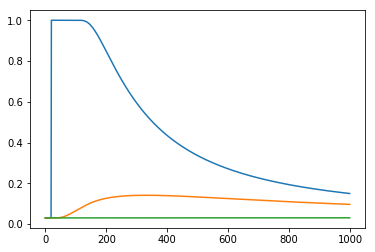

In [50]:
plt.plot(result_point_value[98,:,:])

In [49]:
np.max(result_point_value[98,:,-1])

0.030582209652113765

In [44]:
np.argmax(result_point_value[98,:,1:], axis=0)

array([331, 999])

In [69]:
np.save('result_point_value',result_point_value)

In [70]:
np.save('rsult_R_value',result_R_value)

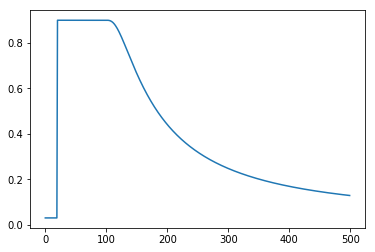

In [68]:
plt.plot(point_value[:,0])

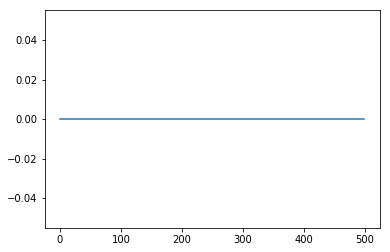

In [69]:
plt.plot(R_value[:,0])

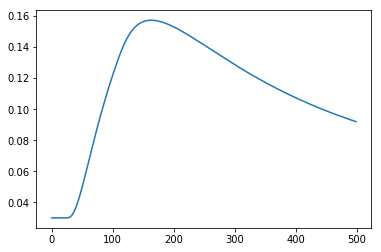

In [70]:
plt.plot(point_value[:,1])

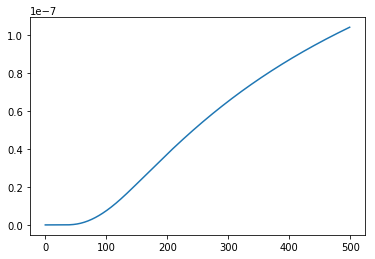

In [71]:
plt.plot(R_value[:,1])